In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import tensorflow as tf
import zipfile

! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmaod 600 ~/.kaggle/kaggle.json

! kaggle datasets download imetomi/eur-usd-forex-pair-historical-data-2002-2019 #scarico il dataset direttamente da kaggle

with zipfile.ZipFile("/content/eur-usd-forex-pair-historical-data-2002-2019.zip", 'r') as zip_ref:
    zip_ref.extractall("/content")

df = pd.read_csv('eurusd_minute.csv',index_col=0,parse_dates=True)
df.drop('Time', inplace=True, axis=1)

df.head()

/bin/bash: chmaod: command not found
 77% 89.0M/116M [00:00<00:00, 99.3MB/s]
100% 116M/116M [00:00<00:00, 126MB/s]  


,BO,BH,BL,BC,BCh,AO,AH,AL,AC,ACh
Date,,,,,,,,,,
2005-01-02,1.3555,1.3555,1.3555,1.3555,0.0,1.3565,1.3565,1.3565,1.3565,0.0
2005-01-02,1.3555,1.3555,1.3555,1.3555,0.0,1.3565,1.3565,1.3565,1.3565,0.0
2005-01-02,1.3562,1.3562,1.3562,1.3562,0.0,1.3572,1.3572,1.3572,1.3572,0.0
2005-01-02,1.3560,1.3560,1.3560,1.3560,0.0,1.3570,1.3570,1.3570,1.3570,0.0
2005-01-02,1.3563,1.3563,1.3563,1.3563,0.0,1.3573,1.3573,1.3573,1.3573,0.0


In [2]:
import datetime

start_train = datetime.datetime(2020, 2, 1,0,0) #un solo mese di train
end_train = datetime.datetime(2020, 2, 28, 0, 0)
start_test = datetime.datetime(2020, 3, 2,0,0) #due settimane di testing
end_test = datetime.datetime(2020, 3, 17, 0, 0)
start_validation=datetime.datetime(2020, 3, 18, 0, 0)
end_validation =datetime.datetime(2020, 3, 18, 23, 59) #un giorno per la validazione

#Prendiamo i dati necessari per il training
df_train=df.loc[start_train:end_train]

#Prendiamo i dati necessari per il testing
df_test=df.loc[start_test:end_test]
Y_test2=df_test["BC"].values

#Prendiamo i dati per la validazione
df_validation=df.loc[start_validation:end_validation]

In [3]:
print(df_validation)

                 BO       BH       BL       BC      BCh       AO       AH  \
Date                                                                        
2020-03-18  1.10155  1.10163  1.10149  1.10161 -0.00006  1.10177  1.10184   
2020-03-18  1.10158  1.10159  1.10146  1.10150  0.00008  1.10179  1.10180   
2020-03-18  1.10149  1.10151  1.10089  1.10089  0.00060  1.10169  1.10174   
2020-03-18  1.10091  1.10105  1.10075  1.10086  0.00005  1.10113  1.10132   
2020-03-18  1.10084  1.10088  1.10047  1.10049  0.00035  1.10106  1.10110   
...             ...      ...      ...      ...      ...      ...      ...   
2020-03-18  1.09646  1.09646  1.09602  1.09639  0.00007  1.09683  1.09683   
2020-03-18  1.09636  1.09677  1.09636  1.09673 -0.00037  1.09677  1.09706   
2020-03-18  1.09674  1.09694  1.09608  1.09608  0.00066  1.09701  1.09726   
2020-03-18  1.09609  1.09619  1.09558  1.09563  0.00046  1.09638  1.09645   
2020-03-18  1.09561  1.09568  1.09385  1.09429  0.00132  1.09597  1.09598   

In [4]:
look_back = 15 #prendo gli ultimi 20 elementi da ricordare. Sono partito da 3, poi 5 e poi 10, la differenza nel loss è davvero evidente. 15 è il valore perfetto
X_train, Y_train = [], []
df_trainX=df_train.get(["BO"])
df_trainX=df_trainX.reset_index(drop=True)
X_array=df_trainX.to_numpy() #li trasformo da dataset ad array altrimenti ho problemi dopo nel ciclo?
df_trainY=df_train.get(["BC"])
df_trainY=df_trainY.reset_index(drop=True)
Y_array=df_trainY.to_numpy()

for i in range(len(Y_array)-look_back-1):
		a = X_array[i:(i+look_back)]
		X_train.append(a)
		Y_train.append(Y_array[i + look_back])

np.array(X_train), np.array(Y_train)
print(X_train[:10])
print(Y_train[:10])

[array([[1.10946],
       [1.10929],
       [1.10906],
       [1.10904],
       [1.10909],
       [1.10908],
       [1.10911],
       [1.1091 ],
       [1.10908],
       [1.10903],
       [1.10893],
       [1.10863],
       [1.10887],
       [1.10859],
       [1.10863]]), array([[1.10929],
       [1.10906],
       [1.10904],
       [1.10909],
       [1.10908],
       [1.10911],
       [1.1091 ],
       [1.10908],
       [1.10903],
       [1.10893],
       [1.10863],
       [1.10887],
       [1.10859],
       [1.10863],
       [1.10867]]), array([[1.10906],
       [1.10904],
       [1.10909],
       [1.10908],
       [1.10911],
       [1.1091 ],
       [1.10908],
       [1.10903],
       [1.10893],
       [1.10863],
       [1.10887],
       [1.10859],
       [1.10863],
       [1.10867],
       [1.1085 ]]), array([[1.10904],
       [1.10909],
       [1.10908],
       [1.10911],
       [1.1091 ],
       [1.10908],
       [1.10903],
       [1.10893],
       [1.10863],
       [1.10887],
   

In [5]:
X_test, Y_test = [], []
df_testX=df_test.get(["BO"])
df_testX=df_testX.reset_index(drop=True)
X_array=df_testX.to_numpy() #li trasformo da dataset ad array altrimenti ho problemi dopo nel ciclo?
df_testY=df_test.get(["BC"])
df_testY=df_testY.reset_index(drop=True)
Y_array=df_testY.to_numpy()

for i in range(len(Y_array)-look_back-1):
		a = X_array[i:(i+look_back)]
		X_test.append(a)
		Y_test.append(Y_array[i + look_back])

np.array(X_test), np.array(Y_test)


(array([[[1.10513],
         [1.1051 ],
         [1.10494],
         ...,
         [1.10383],
         [1.10394],
         [1.10402]],
 
        [[1.1051 ],
         [1.10494],
         [1.10476],
         ...,
         [1.10394],
         [1.10402],
         [1.10409]],
 
        [[1.10494],
         [1.10476],
         [1.1043 ],
         ...,
         [1.10402],
         [1.10409],
         [1.104  ]],
 
        ...,
 
        [[1.10158],
         [1.10162],
         [1.10158],
         ...,
         [1.10111],
         [1.10104],
         [1.10108]],
 
        [[1.10162],
         [1.10158],
         [1.10157],
         ...,
         [1.10104],
         [1.10108],
         [1.10106]],
 
        [[1.10158],
         [1.10157],
         [1.10153],
         ...,
         [1.10108],
         [1.10106],
         [1.10119]]]), array([[1.10399],
        [1.10412],
        [1.10401],
        ...,
        [1.10118],
        [1.10119],
        [1.10155]]))

In [6]:
X_validation, Y_validation = [], []
df_validationX=df_validation.get(["BO"])
df_validationX=df_validationX.reset_index(drop=True)
X_array=df_validationX.to_numpy() #li trasformo da dataset ad array altrimenti ho problemi dopo nel ciclo?
df_validationY=df_validation.get(["BC"])
df_validationY=df_validationY.reset_index(drop=True)
Y_array=df_validationY.to_numpy()

for i in range(len(Y_array)-look_back-1):
		a = X_array[i:(i+look_back)]
		X_validation.append(a)
		Y_validation.append(Y_array[i + look_back])

np.array(X_validation), np.array(Y_validation)

(array([[[1.10155],
         [1.10158],
         [1.10149],
         ...,
         [1.10059],
         [1.10059],
         [1.10019]],
 
        [[1.10158],
         [1.10149],
         [1.10091],
         ...,
         [1.10059],
         [1.10019],
         [1.10016]],
 
        [[1.10149],
         [1.10091],
         [1.10084],
         ...,
         [1.10019],
         [1.10016],
         [1.10009]],
 
        ...,
 
        [[1.09735],
         [1.09705],
         [1.09557],
         ...,
         [1.09606],
         [1.0962 ],
         [1.09646]],
 
        [[1.09705],
         [1.09557],
         [1.09528],
         ...,
         [1.0962 ],
         [1.09646],
         [1.09636]],
 
        [[1.09557],
         [1.09528],
         [1.0953 ],
         ...,
         [1.09646],
         [1.09636],
         [1.09674]]]), array([[1.10007],
        [1.10012],
        [1.10029],
        ...,
        [1.09673],
        [1.09608],
        [1.09563]]))

In [7]:
# create and fit the LSTM 
import tensorflow as tf
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam

In [8]:
print(X_validation)
print("Finito")
print(Y_validation)

[array([[1.10155],
       [1.10158],
       [1.10149],
       [1.10091],
       [1.10084],
       [1.10051],
       [1.10069],
       [1.10079],
       [1.10074],
       [1.10051],
       [1.10031],
       [1.10048],
       [1.10059],
       [1.10059],
       [1.10019]]), array([[1.10158],
       [1.10149],
       [1.10091],
       [1.10084],
       [1.10051],
       [1.10069],
       [1.10079],
       [1.10074],
       [1.10051],
       [1.10031],
       [1.10048],
       [1.10059],
       [1.10059],
       [1.10019],
       [1.10016]]), array([[1.10149],
       [1.10091],
       [1.10084],
       [1.10051],
       [1.10069],
       [1.10079],
       [1.10074],
       [1.10051],
       [1.10031],
       [1.10048],
       [1.10059],
       [1.10059],
       [1.10019],
       [1.10016],
       [1.10009]]), array([[1.10091],
       [1.10084],
       [1.10051],
       [1.10069],
       [1.10079],
       [1.10074],
       [1.10051],
       [1.10031],
       [1.10048],
       [1.10059],
   

In [9]:
# reshape input to be [samples, time steps, features] (form for neural network)           PERCHE' DEVO FARE COSI'?
X_train = np.asarray(X_train)
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.asarray(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))
X_validation = np.asarray(X_validation)
X_validation = np.reshape(X_validation, (X_validation.shape[0], 1, X_validation.shape[1]))
Y_validation = np.asarray(Y_validation)
Y_test = np.asarray(Y_test)

model = Sequential()
model.add(LSTM(3, input_shape=(1, look_back))) #3 neuroni
model.add(Dense(1))
checkpoint = ModelCheckpoint("prevision.h5", monitor='loss', verbose=1, save_best_only=True)

model.compile(loss="mean_absolute_error",optimizer=Adam(learning_rate=0.001)) #è giusta la categorical accuracy?

#for i in range(0,X_train.size-10000,10000):
#15 valori precedenti + allenamento con 100 epochs dà una precisione assurda
history=model.fit(np.array(X_train),np.array(Y_train),validation_data=(X_test, Y_test),epochs=35,batch_size=64,verbose=2) #non serve il for perchè non sono troppi campioni

# make predictions
#trainPredict = model.predict(X_train)
#testPredict = model.predict(X_test)

Epoch 1/35
433/433 - 4s - loss: 0.1356 - val_loss: 0.0207 - 4s/epoch - 10ms/step
Epoch 2/35
433/433 - 2s - loss: 0.0046 - val_loss: 0.0188 - 2s/epoch - 3ms/step
Epoch 3/35
433/433 - 1s - loss: 0.0043 - val_loss: 0.0173 - 1s/epoch - 3ms/step
Epoch 4/35
433/433 - 1s - loss: 0.0038 - val_loss: 0.0141 - 1s/epoch - 3ms/step
Epoch 5/35
433/433 - 1s - loss: 0.0034 - val_loss: 0.0140 - 1s/epoch - 3ms/step
Epoch 6/35
433/433 - 1s - loss: 0.0029 - val_loss: 0.0136 - 1s/epoch - 3ms/step
Epoch 7/35
433/433 - 1s - loss: 0.0027 - val_loss: 0.0105 - 1s/epoch - 3ms/step
Epoch 8/35
433/433 - 1s - loss: 0.0024 - val_loss: 0.0089 - 1s/epoch - 3ms/step
Epoch 9/35
433/433 - 1s - loss: 0.0022 - val_loss: 0.0083 - 1s/epoch - 3ms/step
Epoch 10/35
433/433 - 1s - loss: 0.0021 - val_loss: 0.0083 - 1s/epoch - 3ms/step
Epoch 11/35
433/433 - 2s - loss: 0.0019 - val_loss: 0.0066 - 2s/epoch - 3ms/step
Epoch 12/35
433/433 - 1s - loss: 0.0018 - val_loss: 0.0077 - 1s/epoch - 3ms/step
Epoch 13/35
433/433 - 2s - loss: 0.0

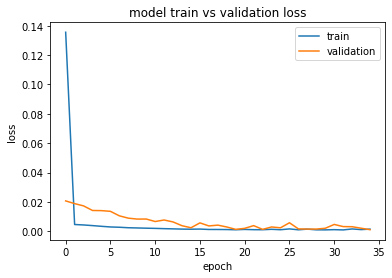

In [10]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'])
pyplot.plot(history.history['val_loss'])
pyplot.title('model train vs validation loss')
pyplot.ylabel('loss')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'validation'], loc='upper right')
pyplot.show()

#eppure avrei scommesso che con 100 epoche andasse in overfitting, btw 27 epoche bastano

In [11]:
testPredict = model.predict(X_validation)

44/44 [==============================] - 1s 2ms/step


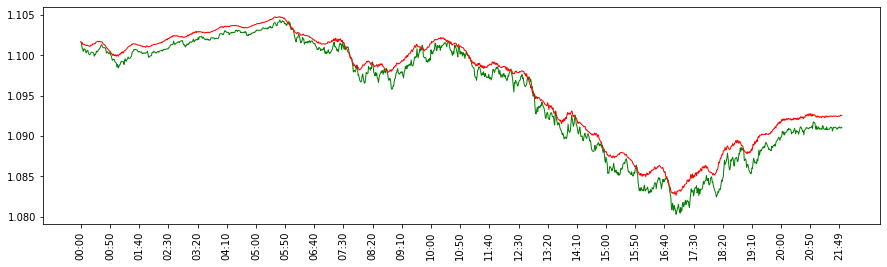

In [12]:
#Grafico valori reali del data test e della predizione per una giornata

df = pd.read_csv('eurusd_minute.csv')
df["timestamp"]=df['Date'].astype(str) +" "+ df["Time"].astype(str)
df=df.drop(axis=1,labels="Date")
df=df.drop(axis=1,labels="Time")
df.set_index("timestamp",drop=True,inplace=True)
df.index = pd.to_datetime(df.index,format="%Y-%m-%d %H:%M")
df.sort_values(by=['timestamp'], inplace = True)

df_test=df.loc['2020-03-18 00:00':'2020-03-18 22:00'] #GIORNO SUL QUALE HO FATTO LA VALIDAZIONE
df_test=df_test.sort_index(axis=1)
Y_test=df_test["BC"].values

#print(df_test)

testPredict=np.asarray(testPredict)
testPredict=testPredict.flatten() #perchè veniva vista come una matrice [x,1], in questo modo è un semplice vettore

f = plt.figure()
f.set_figwidth(15)
labels = df_test.index.strftime('%H:%M')
plt.plot(labels,Y_test[:len(labels)],color='green',linewidth=1)
plt.plot(labels,testPredict[:len(labels)],color='red',linewidth=1)
plt.xticks(rotation=90)
plt.xticks(np.arange(0, len(labels), 50))
plt.show()